In [2]:
import json 
import pandas as pd
import numpy as np
from tqdm import tqdm

In [3]:
# triples with original refs
# 30 dropout runs    
# each triple has mean and std score

# f = open ('/media/hdd1/glushkovato/comet/segments.json', "r") 
# f = open ('/media/hdd1/glushkovato/comet/test-out.json', "r") 
f = open ('/media/hdd1/glushkovato/comet/segments-arp-ref-norm.json', "r") 

data = json.loads(f.read()) 
f.close() 

In [31]:
tmp_list = np.arange(5*3)
for i in range(0, len(tmp_list), 3):
    print(i)
    print(tmp_list[i:i+3])

0
[0 1 2]
3
[3 4 5]
6
[6 7 8]
9
[ 9 10 11]
12
[12 13 14]


In [32]:
tmp_list

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [4]:
data[0]

{'src': "Welsh AMs worried about 'looking like muppets'",
 'mt': 'Waliser AMs besorgt darüber, „wie Muppets auszusehen“',
 'ref': 'Abgeordnete aus Wales hatten Angst, das Bild von „Dummköpfen“ abzugeben.',
 'predicted_score_mean': -2.9176501719253505,
 'predicted_score_std': 0.07270077603323168}

In [3]:
# data[0]

{'src': "Welsh AMs worried about 'looking like muppets'",
 'mt': 'Waliser AMs besorgt darüber, „wie Muppets auszusehen“',
 'ref': 'Walisische Ageordnete sorgen sich "wie Dödel auszusehen"',
 'predicted_score_mean': 0.020787975875039895,
 'predicted_score_std': 0.03779939989487407}

In [5]:
lines = []
for i in data:
    lines.append([i['src'], i['mt'], i['ref'], i['predicted_score_mean'], i['predicted_score_std']])

In [6]:
df = pd.DataFrame(data=np.array(lines), 
                  columns=['src','mt', 'ref', 'predicted_score_mean','predicted_score_std'])

df.iloc[:3]

,src,mt,ref,predicted_score_mean,predicted_score_std
0,Welsh AMs worried about 'looking like muppets',"Waliser AMs besorgt darüber, „wie Muppets ausz...","Abgeordnete aus Wales hatten Angst, das Bild v...",-2.9176501719253505,0.07270077603323168
1,There is consternation among some AMs at a sug...,Bei einigen AMs herrscht Bestürzung über einen...,Mehrere AMs zeigten sich betroffen angesichts ...,0.30622523561877824,0.11615332493598031
2,It has arisen because of plans to change the n...,"Sie ist aufgrund von Plänen entstanden, den Na...","Dazu kam es aufgrund von Ideen, die Versammlun...",0.004673435747534851,0.08099723127637815


In [7]:
da_scores = pd.read_csv('/media/hdd1/glushkovato/comet/COMET_uncertainty/data/da_scores_combined_ref.csv')
da_scores.iloc[:3]

,src,ref,extra_ref,Facebook_FAIR.6862,SID,raw_score,z_score,z_score_norm,raw_score_norm,annotators
0,Welsh AMs worried about 'looking like muppets',"Walisische Ageordnete sorgen sich ""wie Dödel a...","Walisische Abgeordnete befürchten als ,Idioten...","Waliser AMs besorgt darüber, „wie Muppets ausz...",0,NaN,NaN,NaN,NaN,NaN
1,There is consternation among some AMs at a sug...,Es herrscht Bestürzung unter einigen Mitgliede...,Bei einigen AMs herrscht Fassungslosigkeit übe...,Bei einigen AMs herrscht Bestürzung über einen...,1,96.5,0.696150,0.591311,0.410417,2.0
2,It has arisen because of plans to change the n...,"Der Grund dafür waren Pläne, den Namen der Nat...","Es kam wegen Plänen auf, den Namen der Versamm...","Sie ist aufgrund von Plänen entstanden, den Na...",2,68.0,-0.652806,-1.690535,-1.485173,1.0


In [8]:
df['z_score'] = da_scores['z_score'].tolist()
df['z_score_norm'] = da_scores['z_score_norm'].tolist()

cols = ['predicted_score_mean', 'predicted_score_std', 'z_score', 'z_score_norm']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [9]:
df.head()

,src,mt,ref,predicted_score_mean,predicted_score_std,z_score,z_score_norm
0,Welsh AMs worried about 'looking like muppets',"Waliser AMs besorgt darüber, „wie Muppets ausz...","Abgeordnete aus Wales hatten Angst, das Bild v...",-2.917650,0.072701,NaN,NaN
1,There is consternation among some AMs at a sug...,Bei einigen AMs herrscht Bestürzung über einen...,Mehrere AMs zeigten sich betroffen angesichts ...,0.306225,0.116153,0.696150,0.591311
2,It has arisen because of plans to change the n...,"Sie ist aufgrund von Plänen entstanden, den Na...","Dazu kam es aufgrund von Ideen, die Versammlun...",0.004673,0.080997,-0.652806,-1.690535
3,AMs across the political spectrum are worried ...,AMs im gesamten politischen Spektrum sind beso...,Assembly Members aus allen Parteien haben Angs...,-0.637937,0.097642,-0.013827,-0.609661
4,"One Labour AM said his group was concerned ""it...","Ein Labour AM sagte, seine Gruppe sei besorgt,...",Laut Aussage eines Abgeordneten der Labour-Par...,-0.365621,0.080398,0.246498,-0.169304


In [10]:
df.shape

(1997, 7)

In [11]:
df = df.dropna()
df.shape

(1744, 7)

In [12]:
z_scores = df['z_score'].tolist()
z_scores_norm = df['z_score_norm'].tolist()
mean_vals = df['predicted_score_mean'].tolist()
std_vals = df['predicted_score_std'].tolist()

## data plots

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Math, Latex
from IPython.core.display import Image
import seaborn as sns
sns.set(color_codes=True)

sns.set(rc={'figure.figsize':(10,5)}) # seaborn plot sizes

### test example

In [13]:
from scipy.stats import norm

data_normal = norm.rvs(size=10000,loc=0,scale=1) # random numbers from N(0,1)

In [14]:
# np.log(norm.pdf(data_normal, np.mean(data_normal), np.mean(data_normal))+eps).sum()

/media/hdd1/glushkovato/comet/py37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'Normal Distribution'), Text(0, 0.5, 'Frequency')]

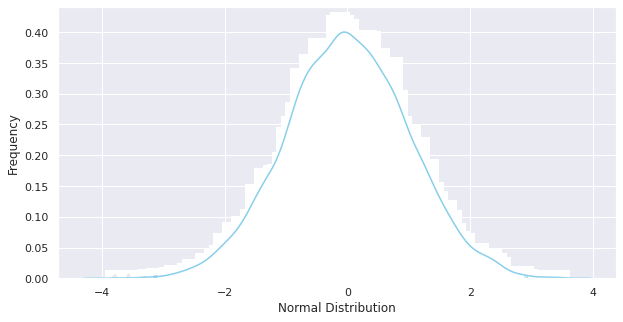

In [15]:
ax = sns.distplot(sorted(data_normal),
                  bins=100,
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='Normal Distribution', ylabel='Frequency')

### our data

mean values for each triple

/media/hdd1/glushkovato/comet/py37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'mean_vals distribution'), Text(0, 0.5, 'Frequency')]

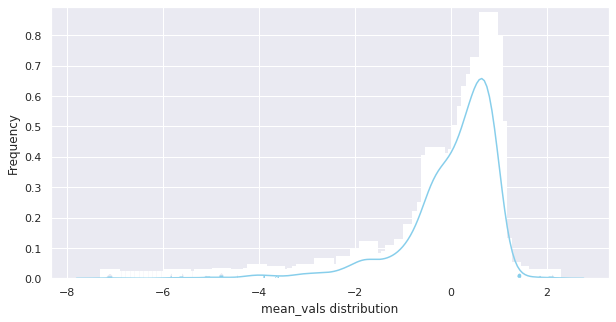

In [14]:
ax = sns.distplot(mean_vals,
                  bins=100,
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})

ax.set(xlabel='mean_vals distribution', ylabel='Frequency')

/media/hdd1/glushkovato/comet/py37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'z_scores distribution'), Text(0, 0.5, 'Frequency')]

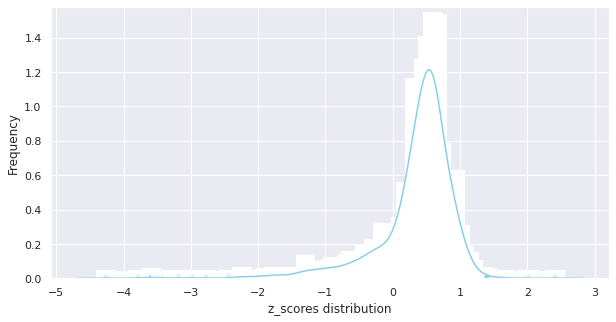

In [15]:
ax = sns.distplot(z_scores,
                  bins=100,
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})

ax.set(xlabel='z_scores distribution', ylabel='Frequency')

In [16]:
mean = np.mean(mean_vals)
std = np.std(mean_vals)

print('mean: ', mean)
print('std: ', std)

mean:  0.03450103589586551
std:  0.9602975816160306


In [17]:
np.mean(z_scores)

0.34679193216427295

In [18]:
np.mean(mean_vals)

0.03450103589586551

## evaluation based on the log-likelihood metric  
log p(q | mu, sigma_sq) 


In [19]:
from scipy.stats import norm

In [20]:
mean = np.mean(mean_vals)
std = np.std(mean_vals)

In [21]:
eps = np.finfo(float).eps # to avoid -inf when computing np.log(0)
eps

2.220446049250313e-16

In [35]:
tmp = []
probs = []
for i, q in enumerate(z_scores):
    prob = norm.pdf(q, mean_vals[i], std_vals[i])
    probs.append(prob)
    tmp.append(np.log(prob+eps))

In [75]:
# z_scores[:50]

In [76]:
# std_vals[:50]

In [77]:
# mean_vals[:50]

In [23]:
probs[:20]

[0.16895659881068237,
 3.758199325643302e-95,
 3.917984524348979,
 0.25173698516247667,
 4.399268375041114e-20,
 2.5923804550908607e-06,
 2.924535575568911e-26,
 1.804980532324602e-37,
 2.0973786381803266e-05,
 3.0185151890132144e-97,
 4.668383171965241e-48,
 0.012168154790960865,
 0.45822684316628415,
 4.420048384029329e-36,
 3.532563042791329e-05,
 1.3716952194326665e-48,
 1.9785576933283022e-07,
 6.543260270701636e-19,
 5.886023605555734e-12,
 6.615780177064418e-16]

In [24]:
np.sum(np.log(probs+eps))

-33847.912315981535

In [116]:
np.sum(np.log(probs+eps))

-20743.219915725025

In [36]:
np.sum(np.log(probs+eps))/len(probs) #! the value we want to compare (want: as big as possible) 
# z_scores and norm comet

-17.02145588847603

In [41]:
(0.3478988424802117+0.32872467062016925+0.11685357341357375)/3

0.2644923621713182

In [39]:
s = [[0.3478988424802117, -0.4081405360892739, 0.33500615178881393], 
     [0.32872467062016925, -2.2810152700178628, 0.5426251054257093], 
     [0.11685357341357375, -0.4812299745324474, 0.05652160583203741]]

np.mean(s, axis=0)

array([ 0.26449236, -1.05679526,  0.31138429])

In [89]:
np.sum(np.log(probs+eps))/len(probs) #! the value we want to compare (want: as big as possible) 
# z_scores and not norm comet

-22.17159822800405

In [117]:
np.sum(np.log(probs+eps))/len(probs) #! the value we want to compare (want: as big as possible) 
# z_scores and norm comet

-11.894048116814808

In [122]:
np.sum(np.log(probs+eps))/len(probs) #! the value we want to compare (want: as big as possible) 
# norm z_scores and norm comet

-14.173659699440242

In [93]:
# or as small as possible
np.abs(np.sum(np.log(probs+eps))/len(probs)) #! the value we want to compare 

22.17159822800405

In [ ]:
# try norm.logpdf

In [147]:
norm.var(mean_vals[0],0.01)

0.0001

In [142]:
# var starting from 0.001 to 0.5, step 0.001

vals = []
for j in tqdm(np.arange(0.5, 0.8, 0.001)): 
    probs = []
    for i, q in enumerate(z_scores):
        prob = norm.pdf(q, mean_vals[i], j)
        probs.append(prob)
    vals.append(np.sum(np.log(probs+eps))/len(probs))

100%|██████████| 301/301 [00:53<00:00,  5.61it/s]


In [143]:
np.argmax(vals)

300

In [144]:
vals[np.argmax(vals)]

-1.6878358116439027

In [137]:
np.arange(0.001, 0.5, 0.001)[498]

0.499

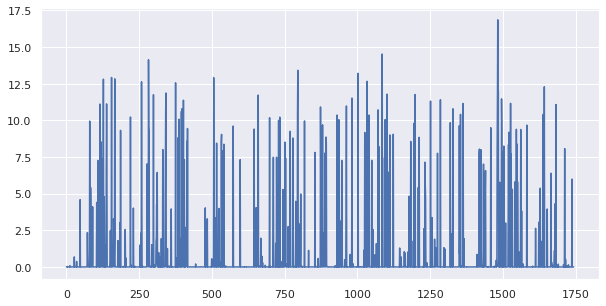

In [69]:
plt.plot(probs, color='b')

/media/hdd1/glushkovato/comet/py37_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


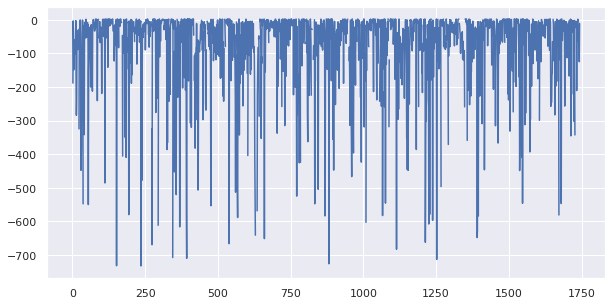

In [88]:
plt.plot(np.log(probs), color='b')

In [35]:
np.sum(tmp)

-37572.37062613824

In [74]:
np.log(norm.pdf(z_scores, mean, std))

array([  0.35527887, -10.78837592,  -2.41678263, ...,   0.38723281,
         0.18440155,   0.38723281])

In [72]:
np.log(norm.pdf(z_scores, mean, std)).sum()

-4415.865239777251

In [73]:
# np.log(norm.pdf(z_scores_norm, mean, std)).sum()

In [24]:
probs = norm.pdf(z_scores, mean, std)
probs

array([1.42657842e+00, 2.06380123e-05, 8.92081720e-02, ...,
       1.47289936e+00, 1.20249859e+00, 1.47289936e+00])

In [25]:
np.array(probs).any() >= 1

True

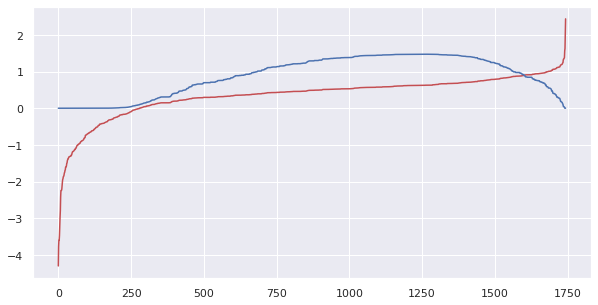

In [28]:
z_scores, probs = zip(*sorted(zip(z_scores, probs)))

plt.plot(z_scores, color='r')
plt.plot(probs, color='b')
# plt.plot(np.log(probs), color='g')
plt.show()